## Project Explanation ##

### 1. Purpose of the Project ###

Board interlock refers to the practice of members of a corporate board of directors serving on the boards of multiple corporations. It is a critical topic for understanding the relationships among corporates. By using methodologies from network analysis, this software project will analyze the network among Chinese foundations using Python and a comprehensive dataset of foundations’ board members. Specifically, I take the following steps to examine the research question.

#### 1.1 Construct the network by matching the board member.####

For the organizational network of foundations as nodes, a link between two nodes (i.e., foundations) means they have one or more board members in common, and the link is weighted by the number of board members they share. The board member is matched according to the name, gender, and date of birth.

#### 1.2 Visualize the overall network. ####

According to the registration policy, there are two types of Chinese foundations: public foundations (PUFs) which are allowed to fundraise from the general public, and private foundations (PRFs) which can only receive funds from private sources. In the visualization, PUFs are colorized as yellow, PRFs are colorized as blue.

#### 1.3 Rich-club phenomenon in the networks. ####

The ‘rich-club’ phenomenon refers to the trend of nodes with high importance to form tightly interconnected communities, and it is one of the crucial properties accounting for the formation of dominant communities in both computer and social sciences. I will examine the presence of rich-club in the overall network, PUFs network, and PRFs network.

#### 1.4 Which kind of foundations is controlling the network? ####

Scholars have agreed that the PUFs (public foundations) are controlled by the government, and through the PUFs, the government can control the network of the overall foundations. Therefore, I would like to examine whether PUFs hold more important positions than PRFs (private foundations) in the network.

"Important position" is operationalized by four types of centrality values, i.e., degree centrality, closeness centrality, betweenness centrality, and eigenvector centrality. *Degree centrality* measures a given node’s direct connection with other nodes. *Closeness centrality* measures the sum of geodesic distances from a given node to all the other nodes in the network. *Betweenness centrality* measures how often a given node falls along the shortest path between two other nodes. *Eigenvector centrality* computes the centrality for a node based on the centrality of its neighbors. In order to control the network, PUF should have higher centrality values than PRF according to statistical analysis.

#### 1.5 The maximal cliques and PUF's percentage in each clique. ####

A maximal clique is a complete subgraph that cannot be extended by including one more adjacent vertex. Each node connects with all the other nodes in a maximal clique, indicating that “everyone knows everyone.” It is the most cohesive community structure in the network. In order to control the cliques, PUF should be dominant in the cliques (i.e., percentage of PUF should be more than 50%). This percentage value will be examined by one-sample t test.

### 2. Dataset and Software ###

The dataset, provided by the Research Infrastructure of China Foundations (http://ssrn.com/abstract=2673879), is comprehensive and verifiable. It consists of 3,344 Chinese foundations’ basic information (from *Basic* table) and 34,395 board member records from 2,847 foundations (from *Board* table).

Python NetworkX library and SPSS 22 are used for the network and statistical analysis respectively.

## Coding Begins ##

### 0. Import modules, define fuctions, and read data into variables.###

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

# ======== Import Modules ========
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ======== Define Functions ========
def Func_Foundation_Type(FoundationID):
    for i in FoundationBasic:
        if i[0] == FoundationID:
            if i[10] == '公募':
                return 'PUF'
            if i[10] == '非公募':
                return 'PRF'
            else:
                return 'NA'

def Func_Working_Area(FoundationID):
    for i in FoundationBasic:
        if i[0] == FoundationID:
            if i[9] == 'Favorable':
                return 'FAV'
            if i[9] == 'Unfavorable':
                return 'UFA'
            else:
                return 'NA'

def Func_PUF_Percentage(CliqueMemberList):
    count = 0
    for i in CliqueMemberList:
        if Func_Foundation_Type(i) == 'PUF':
            count += 1
    return float(count)/float(len(CliqueMemberList))

# ======== Read Data into Variables ========
# Exclude the title line.
# Data format: Council Member ID[0], Foundation ID[1], Year[2],
# Name[3], Gender[4], DOB[5], Board position[6], Job position[7]
CouncilDataFile = 'council2013.csv'
dataList = [g for g in csv.reader(open(CouncilDataFile, 'r'), delimiter='	')][2:]
# FoundationBasic[0] = FoundationID, FoundationBasic[10] = FoundationType.
FoundationBasic = [g for g in csv.reader(open('FoundationBasic.csv', 'r'), delimiter='	')][2:]

print 'The file has %s lines of records.' % len(dataList)
print 'The file has board member data of %s foundations.' % len(set([s[1] for s in dataList]))

The file has 34395 lines of records.
The file has board member data of 2847 foundations.


### 1.1 Construct the network by matching the board member.

In [2]:
# Create a member dict. for fast matching.
# Format of dic.:
# {FoundationID1:[[Name1, Gender1, DOB1],[Name2,...]...],...}

MemberDict_NF_All = {}
for x in dataList:
    if x[1] not in MemberDict_NF_All:
        CheckingFoundation = [s for s in dataList if s[1]==x[1]]
        TempMemberList = []
        for i in CheckingFoundation:
            TempMemberList.append([i[3], i[4], i[5]])
        MemberDict_NF_All[x[1]] = TempMemberList

EdgeList_NF_All = []
CheckedFoundationID = []
for i in MemberDict_NF_All: # A list of members' information within Foundation-i.
    CheckedFoundationID.append(i)
    for s in MemberDict_NF_All:
        if s != i and s not in CheckedFoundationID:
            # Match all the other foundations and those not checked.
            weight = 0
            for x in MemberDict_NF_All[i]: # Information of one board member in Foundation-i.
                if x in MemberDict_NF_All[s]:
                    weight += 1
            if weight != 0:
                EdgeList_NF_All.append((i, s, weight))
print EdgeList_NF_All[0:5]

[('344', '346', 1), ('344', '1542', 1), ('345', '1772', 1), ('345', '2908', 1), ('346', '339', 1)]


### 1.2 Visualize the overall network.###

The overall network has 3344 nodes and 1880 edges.
3344 nodes has been colorized according to foundation types.


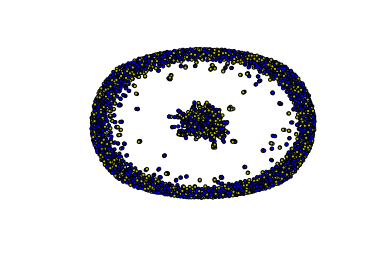

In [7]:
NodeList_NF_All = []
NodeList_NF_All = [s[0] for s in FoundationBasic]

# Colorization by foundation type: PUF = yellow; PRF = blue.
NodeColor_NF_All = []
for i in NodeList_NF_All:
    if Func_Foundation_Type(i) == 'PUF':
        NodeColor_NF_All.append('y')
    if Func_Foundation_Type(i) == 'PRF':
        NodeColor_NF_All.append('b')

# Print out the values.
print 'The overall network has %s nodes and %s edges.' % (len(NodeList_NF_All), len(EdgeList_NF_All))
print '%s nodes has been colorized according to foundation types.' % len(NodeColor_NF_All)

# Draw and show the complete ONF.
G_NF_All = nx.Graph()
G_NF_All.add_nodes_from(NodeList_NF_All)
G_NF_All.add_weighted_edges_from(EdgeList_NF_All)
nx.draw_networkx(G_NF_All, nodelist=NodeList_NF_All, node_color=NodeColor_NF_All,
                 node_size=10, edge_color='0.3', width=0.5, with_labels=False,
                 pos=nx.spring_layout(G_NF_All))
plt.axis('off')
plt.show()

#### Results obtained####
The overall network of Chinese foundations consists of 3,344 nodes and 1,880 edges. The nodes are colorized by their types, i.e., PUF as yellow and PRF as blue. The overall network is messy and has lots of isolated nodes which form a circle.

### 1.3 Rich-club phenomenon in the networks.

In [4]:
# ============ RC in overall network ============
RC = nx.rich_club_coefficient(G_NF_All, normalized=True, Q=1000)
print '===Rich Club Coefficient in OVERALL Network (%s Nodes, %s Edges)===' % (len(list(G_NF_All.nodes())), len(list(G_NF_All.edges())))
print 'K' + '	' + 'RC Coefficient'
for i in RC:
    print str(i) + '	' + str(RC[i])

# ============ RC in PUF network ============
# Construct the PUF network.
NodeList_NF_PUF_All = []
EdgeList_NF_PUF_All = []
for i in NodeList_NF_All:
    if Func_Foundation_Type(i) == 'PUF':
        NodeList_NF_PUF_All.append(i)
for i in EdgeList_NF_All:
    if list(i)[0] in NodeList_NF_PUF_All and list(i)[1] in NodeList_NF_PUF_All:
        EdgeList_NF_PUF_All.append(i)

# Draw the graph and compute the coefficient.
G_NF_PUF_All = nx.Graph()
G_NF_PUF_All.add_nodes_from(NodeList_NF_PUF_All)
G_NF_PUF_All.add_weighted_edges_from(EdgeList_NF_PUF_All)
RC = nx.rich_club_coefficient(G_NF_PUF_All, normalized=True, Q=1000)
print '===Rich Club Coefficient in PUF Network (%s Nodes, %s Edges)===' % (len(list(G_NF_PUF_All.nodes())), len(list(G_NF_PUF_All.edges())))
print 'K' + '	' + 'RC Coefficient'
for i in RC:
    print str(i) + '	' + str(RC[i])

# ============ RC in PRF network ============
# Construct the PRF network.
NodeList_NF_PRF_All = []
EdgeList_NF_PRF_All = []
for i in NodeList_NF_All:
    if Func_Foundation_Type(i) == 'PRF':
        NodeList_NF_PRF_All.append(i)
for i in EdgeList_NF_All:
    if list(i)[0] in NodeList_NF_PRF_All and list(i)[1] in NodeList_NF_PRF_All:
        EdgeList_NF_PRF_All.append(i)

# Draw the graph and compute the coefficient.
G_NF_PRF_All = nx.Graph()
G_NF_PRF_All.add_nodes_from(NodeList_NF_PRF_All)
G_NF_PRF_All.add_weighted_edges_from(EdgeList_NF_PRF_All)
RC = nx.rich_club_coefficient(G_NF_PRF_All, normalized=True, Q=1000)
print '===Rich Club Coefficient in PRF Network (%s Nodes, %s Edges)===' % (len(list(G_NF_PRF_All.nodes())), len(list(G_NF_PRF_All.edges())))
print 'K' + '	' + 'RC Coefficient'
for i in RC:
    print str(i) + '	' + str(RC[i])

===Rich Club Coefficient in OVERALL Network (3344 Nodes, 1880 Edges)===
K	RC Coefficient
0	1.0
1	1.03959627329
2	1.14303030303
3	1.22862129145
4	1.36147757256
5	1.51310861423
6	1.78285714286
7	1.94736842105
8	2.15476190476
9	2.7358490566
10	2.26829268293
11	3.28571428571
12	5.0
13	6.11111111111
14	8.0
15	10.25
16	10.25
17	8.75
18	16.0
19	11.0
20	8.0
21	3.0
===Rich Club Coefficient in PUF Network (1310 Nodes, 495 Edges)===
K	RC Coefficient
0	1.0
1	1.05617977528
2	1.184
3	1.52
4	2.0
5	3.0
6	1.0
7	1.0
===Rich Club Coefficient in PRF Network (2034 Nodes, 580 Edges)===
K	RC Coefficient
0	1.0
1	1.08974358974
2	1.31395348837
3	1.58333333333
4	1.77941176471
5	2.1914893617
6	2.57575757576
7	4.92857142857
8	5.81818181818
9	3.77777777778
10	4.16666666667
11	6.5
12	6.5
13	4.0
14	1.0


#### Results obtained####

As Figure 2 in the *Project Report* shows, the rich-club phenomenon is obvious in the overall network of Chinese foundations (characterized by the progressively increases of coefficient with the increasing degree k). It is more salient in the network of PRFs than in the PUFs (Figure 3).

#### Note:####
The exact coefficient values will be different in each experiment round.

### 1.4 Which kind of foundations is controlling the network?###

In [5]:
# Compare the nodes' centralities.

DegCenDict_NF_All = nx.degree_centrality(G_NF_All)
ClsCenDict_NF_All = nx.closeness_centrality(G_NF_All)
BtwCenDict_NF_All = nx.betweenness_centrality(G_NF_All)
EigCenDict_NF_All = nx.eigenvector_centrality(G_NF_All, tol=1.0e-5)

df_Centralities = pd.DataFrame(dict(FoundationID = pd.Series([s for s in G_NF_All.nodes()], dtype='int32'),
                                   FoundationType = pd.Series([Func_Foundation_Type(s) for s in G_NF_All.nodes()], dtype='category'),
                                   WorkingArea = pd.Series([Func_Working_Area(s) for s in G_NF_All.nodes()], dtype='category'),
                                   DegCen = pd.Series([DegCenDict_NF_All[s] for s in G_NF_All.nodes()], dtype='float64'),
                                   ClsCen = pd.Series([ClsCenDict_NF_All[s] for s in G_NF_All.nodes()], dtype='float64'),
                                   BtwCen = pd.Series([BtwCenDict_NF_All[s] for s in G_NF_All.nodes()], dtype='float64'),
                                   EigCen = pd.Series([EigCenDict_NF_All[s] for s in G_NF_All.nodes()], dtype='float64')))
df_Centralities.to_csv('NF_All_Centralities.csv', sep='	')

print 'FoundationID' + '	' + 'FoundationType' + '	' + 'WorkingArea' + '	' + 'DegCen' + '	' + 'ClsCen' + '	' + 'BtwCen' + '	' + 'EigCen'
for i in G_NF_All.nodes():
    print str(i) + '	' + Func_Foundation_Type(i) + '	' + Func_Working_Area(i) + '	' + str(DegCenDict_NF_All[i]) + '	' + str(ClsCenDict_NF_All[i]) + '	' + str(BtwCenDict_NF_All[i]) + '	' + str(EigCenDict_NF_All[i])


FoundationID	FoundationType	WorkingArea	DegCen	ClsCen	BtwCen	EigCen
344	PUF	FAV	0.000598265031409	0.0412037702422	8.98581545899e-05	4.98082713272e-07
345	PUF	FAV	0.000598265031409	0.0375484807144	0.000739686148947	2.13574042877e-07
346	PUF	UFA	0.000897397547113	0.0457643810329	0.000332520571428	8.33322364363e-06
347	PUF	FAV	0.000299132515704	0.0426685016953	0.0	1.10348011419e-05
340	PUF	FAV	0.0	0.0	0.0	0.0
341	PUF	UFA	0.000299132515704	0.000299132515704	0.0	1.33768338608e-112
342	PRF	FAV	0.0	0.0	0.0	0.0
343	PUF	FAV	0.0	0.0	0.0	0.0
2918	PRF	FAV	0.0	0.0	0.0	0.0
348	PRF	FAV	0.0	0.0	0.0	0.0
349	PUF	UFA	0.0	0.0	0.0	0.0
3002	PRF	FAV	0.0	0.0	0.0	0.0
2919	PRF	FAV	0.0	0.0	0.0	0.0
1653	PRF	FAV	0.000299132515704	0.000398843354273	0.0	7.38186103355e-58
2318	PRF	FAV	0.0	0.0	0.0	0.0
2319	PRF	FAV	0.0	0.0	0.0	0.0
2316	PRF	FAV	0.0	0.0	0.0	0.0
2317	PRF	FAV	0.0	0.0	0.0	0.0
2314	PUF	FAV	0.000299132515704	0.000299132515704	0.0	1.33768338608e-112
2315	PRF	FAV	0.0	0.0	0.0	0.0
2312	PUF	FAV	0.00209392760993	0.

#### Results obtained####

Results of statistical analysis are showed in the Table 1 (in the *Project Report*). Positions held by PUFs in the network are more important than PRF when measured by degree centrality (p = .001), closeness centrality (p = .001), and betweenness centrality (p = .010).

### 1.5 The maximal cliques and PUF's percentage in each clique.###

In [6]:
CliquesList_NF_All = list(nx.find_cliques(G_NF_All))

df = pd.DataFrame(dict(CliqueID = pd.Series([s for s in xrange(0, len(CliquesList_NF_All))], dtype='category'),
                      CliqueSize = pd.Series([len(s) for s in CliquesList_NF_All], dtype='int32'),
                      CliqueMember = pd.Series([str(s) for s in CliquesList_NF_All], dtype='category'),
                      PUFPercentage = pd.Series([Func_PUF_Percentage(s) for s in CliquesList_NF_All], dtype='float64')))
df.to_csv('NF_All_PUF_Percentage.csv', sep='	')

print 'CliqueID#' + '	' + 'CliqueSize' + '	' + 'CliqueMember' + '	' + 'PUF Percentage'
for i in xrange(0, len(CliquesList_NF_All)):
    print str(i) + '	' + str(len(CliquesList_NF_All[i])) + '	' + str(CliquesList_NF_All[i])  + '	' + str(Func_PUF_Percentage(CliquesList_NF_All[i]))


CliqueID#	CliqueSize	CliqueMember	PUF Percentage
0	2	['3253', '3258']	1.0
1	2	['3253', '3270']	1.0
2	1	['1200']	0.0
3	2	['344', '346']	1.0
4	2	['344', '1542']	1.0
5	2	['345', '2908']	0.5
6	2	['345', '1772']	1.0
7	2	['346', '339']	1.0
8	2	['346', '267']	1.0
9	2	['347', '268']	1.0
10	1	['340']	1.0
11	2	['341', '3097']	0.5
12	1	['342']	0.0
13	1	['343']	1.0
14	1	['2918']	0.0
15	1	['348']	0.0
16	1	['349']	1.0
17	1	['2919']	0.0
18	1	['585']	0.0
19	1	['2318']	0.0
20	1	['2319']	0.0
21	1	['2316']	0.0
22	1	['2317']	0.0
23	2	['2314', '1444']	0.5
24	1	['2315']	0.0
25	2	['2312', '2239']	0.5
26	2	['2312', '2310']	1.0
27	3	['2312', '473', '252']	0.666666666667
28	2	['2312', '62']	0.5
29	2	['2312', '3191']	0.5
30	2	['2312', '1900']	0.5
31	3	['2313', '2521', '2519']	0.333333333333
32	2	['2311', '2308']	0.5
33	2	['2311', '526']	0.5
34	3	['298', '1305', '642']	0.666666666667
35	2	['298', '408']	0.0
36	1	['299']	0.0
37	1	['296']	1.0
38	1	['297']	1.0
39	1	['294']	1.0
40	2	['295', '451']	1.0
41	1	['292']	0.

#### Results obtained####

One thousand two hundred and twenty one (1,221) maximal cliques (clique size > 1) are found in the overall network. Statistical analysis shows the percentage of PUF in each clique does not significantly different from 50% (p = .943).

## Results Remark ##

1. The overall network of Chinese foundations consists of 3,344 nodes and 1,880 edges. The overall network is messy and has lots of isolated nodes which form a circle.
2. The rich-club phenomenon is obvious in the overall network of Chinese foundations. It is more salient in the network of PRFs than in the PUFs.
3. PUFs hold more important positions in the network than the PRFs.
4. PUF does not dominate the maximal cliques.